# Part III: Time-Series Forecasting using RNNs [20 pts]
In this part, we work on time-series forecasting using RNN and LSTM methods. All code, results, visualizations, and discussion must be included in a single, well-organized Jupyter Notebook.
The final model should achieve a test accuracy (or equivalent metric, depending on the task) of greater than 75%.

## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the following statistics:
- Number of samples (time points)
- Number of features
- Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)
- Provide a brief description (2-3 sentences) of the dataset: What does it represent? Where does it come from (provide a link)? What are the key variables?

In [ ]:
!pip install torchinfo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('/content/household_power_consumption.txt', sep=';', na_values='?', low_memory=False)
print("Number of samples:", df.shape[0])
print("Number of features:", df.shape[1])
print("\nStatistics for each (numeric) feature:")
print(df.describe())

Number of samples: 2075259
Number of features: 9

Statistics for each (numeric) feature:
       Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        

This dataset tracks the electricity consumption of a single household, recorded every minute over an extended period. It comes from the UCI Machine Learning Repository and provides insights into how energy is used in a home. Key variables include Global Active Power, Voltage, Global Intensity, and Sub-metering values, which help analyze energy patterns and trends.

2. Identify any missing values.

In [ ]:
missing_values = df.isnull().sum()
total_missing = missing_values.sum()
print("\nTotal missing values in DataFrame:", total_missing)


Total missing values in DataFrame: 181853


3. Handle any missing values (imputation or removal).

In [ ]:
df_without_missing_values = df.dropna()
print("Original number of rows in the dataset:", df.shape[0])
print("Number of rows after dropping the rows with missing values:", df_without_missing_values.shape[0])
df = df_without_missing_values

Original number of rows in the dataset: 2075259
Number of rows after dropping the rows with missing values: 2049280


4. Create at least three different visualizations to explore the dataset.

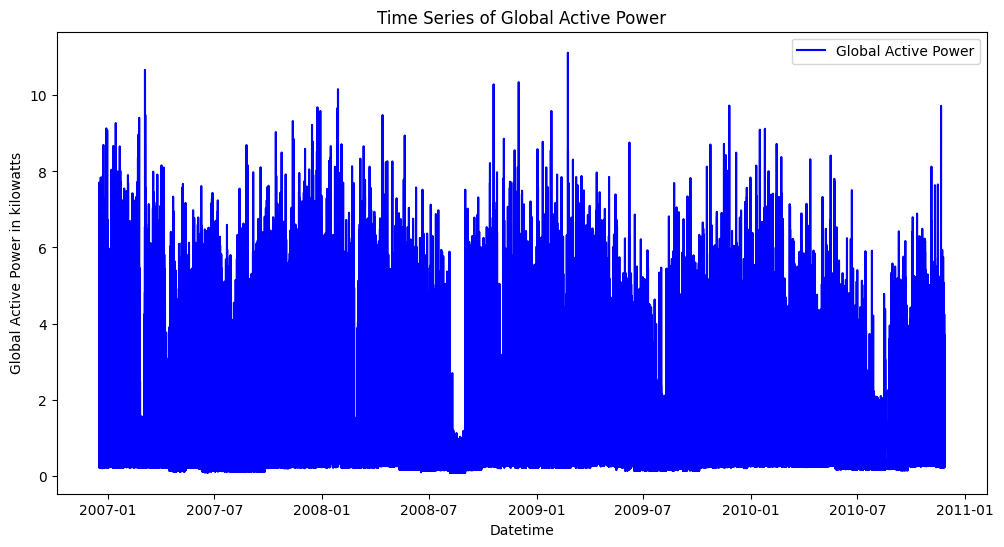

In [ ]:
if 'Date' in df.columns and 'Time' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('Datetime', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Global_active_power'], color='blue', label='Global Active Power')
plt.title('Time Series of Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power in kilowatts')
plt.legend()
plt.show()

It shows global active power consumption (in kilowatts) over the period from 2007 to 2011, with clear fluctuations indicating periods of higher and lower energy usage. The peaks highlight times of increased power consumption, while the dips suggest reduced demand.

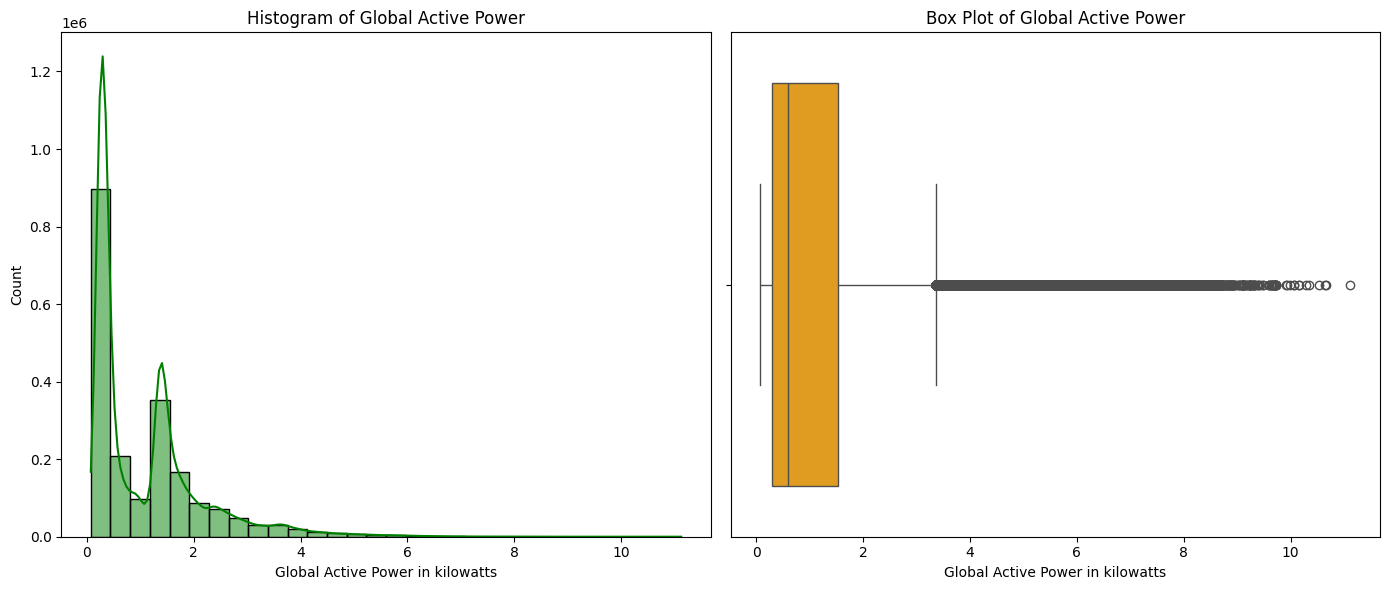

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Global_active_power'].dropna(), bins=30, kde=True, color='green')
plt.title('Histogram of Global Active Power')
plt.xlabel('Global Active Power in kilowatts')
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Global_active_power'].dropna(), color='orange')
plt.title('Box Plot of Global Active Power')
plt.xlabel('Global Active Power in kilowatts')
plt.tight_layout()
plt.show()


These plots illustrate the distribution of global active power, with the histogram showing a right-skewed distribution concentrated at lower kilowatt values and the box plot revealing several outliers at higher consumption levels. Together, they indicate that most observations cluster toward lower power usage, while a smaller subset exhibits significantly higher consumption.

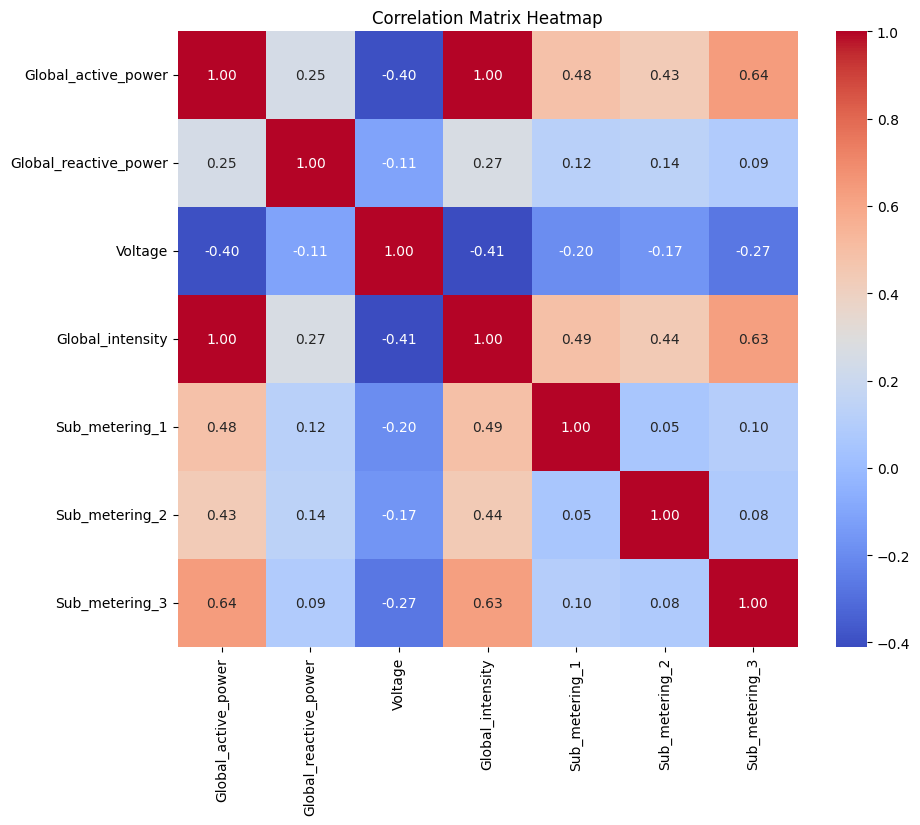

In [ ]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

It shows how various power consumption metrics relate to one another, highlighting a strong positive correlation between global active power and global intensity. In contrast, voltage tends to be negatively correlated with these measures, while the sub-metering variables display moderate positive relationships with overall power usage.

5. Normalize or standardize your data using appropriate techniques.

7. Split the data into training, validation, and testing sets.

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
training_data_size = int(len(df) * 0.7)
validation_data_size = int(len(df) * 0.15)
testing_data_size = len(df) - training_data_size - validation_data_size
training_data = df.iloc[:training_data_size]
validation_data = df.iloc[training_data_size:training_data_size + validation_data_size]
testing_data = df.iloc[training_data_size + validation_data_size:]
scaler = StandardScaler()
scaler.fit(training_data)
train_scaled = scaler.transform(training_data)
val_scaled = scaler.transform(validation_data)
test_scaled = scaler.transform(testing_data)
train_scaled = pd.DataFrame(train_scaled, index=training_data.index, columns=training_data.columns)
val_scaled = pd.DataFrame(val_scaled, index=validation_data.index, columns=validation_data.columns)
test_scaled = pd.DataFrame(test_scaled, index=testing_data.index, columns=testing_data.columns)
print("Training set shape:", train_scaled.shape)
print("Validation set shape:", val_scaled.shape)
print("Test set shape:", test_scaled.shape)

Training set shape: (1434496, 7)
Validation set shape: (307392, 7)
Test set shape: (307392, 7)


6. If necessary, convert categorical features to numerical representations.

The dataset that I chose has only numeric and datetime columns. There are no character or string type columns to be converted to categorical features.

8. Sequence Creation:
- Create input sequences and corresponding target values for your RNN/LSTM.
- Choose a sequence length.
- Create a function to generate sequences.

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [ ]:
sequence_length = 20
training_sequences, training_targets = create_sequences(train_scaled.values, sequence_length)
validation_sequences, validation_targets = create_sequences(val_scaled.values, sequence_length)
testing_sequences, testing_targets = create_sequences(test_scaled.values, sequence_length)
print("Training sequences shape:", training_sequences.shape)
print("Training targets shape:", training_targets.shape)
print("Validation sequences shape:", validation_sequences.shape)
print("Validation targets shape:", validation_targets.shape)
print("Test sequences shape:", testing_sequences.shape)
print("Test targets shape:", testing_targets.shape)

Training sequences shape: (1434476, 20, 7)
Training targets shape: (1434476, 7)
Validation sequences shape: (307372, 20, 7)
Validation targets shape: (307372, 7)
Test sequences shape: (307372, 20, 7)
Test targets shape: (307372, 7)


## Step 2: Model development

1. Choose either an RNN or LSTM network for your time-series forecasting task.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout_rate, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        return out


Using device: cuda


2. Train your model using an appropriate loss function and optimizer.

In [ ]:
input_size = training_sequences.shape[2]
hidden_size = 64
number_layers = 3
output_size = training_targets.shape[1]
dropout_value = 0.2
learning_rate = 0.001
batch_size = 64
number_epochs = 10
patience = 5
model = LSTMModel(input_size, hidden_size, number_layers, output_size, dropout_value).to(device)
summary(model, input_size=(batch_size, sequence_length, input_size))
train_x = torch.tensor(training_sequences, dtype=torch.float32)
train_y = torch.tensor(training_targets, dtype=torch.float32)
val_x = torch.tensor(validation_sequences, dtype=torch.float32)
val_y = torch.tensor(validation_targets, dtype=torch.float32)
test_x = torch.tensor(testing_sequences, dtype=torch.float32)
test_y = torch.tensor(testing_targets, dtype=torch.float32)
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter('runs/lstm_forecasting')
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
train_losses = []
val_losses = []

In [ ]:
for epoch in range(number_epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():

        for val_batch_x, val_batch_y in val_loader:
            val_batch_x = val_batch_x.to(device)
            val_batch_y = val_batch_y.to(device)
            outputs = model(val_batch_x)
            loss = criterion(outputs, val_batch_y)
            running_val_loss += loss.item() * val_batch_x.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)
    print(f"Epoch [{epoch+1}/{number_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

writer.close()

Epoch [1/10], Train Loss: 0.0824, Val Loss: 0.0676
Epoch [2/10], Train Loss: 0.0675, Val Loss: 0.0653
Epoch [3/10], Train Loss: 0.0643, Val Loss: 0.0630
Epoch [4/10], Train Loss: 0.0621, Val Loss: 0.0610
Epoch [5/10], Train Loss: 0.0611, Val Loss: 0.0606
Epoch [6/10], Train Loss: 0.0596, Val Loss: 0.0598
Epoch [7/10], Train Loss: 0.0587, Val Loss: 0.0597
Epoch [8/10], Train Loss: 0.0578, Val Loss: 0.0594
Epoch [9/10], Train Loss: 0.0571, Val Loss: 0.0602
Epoch [10/10], Train Loss: 0.0565, Val Loss: 0.0580


3. Save the weights of the trained neural network that provides the best results.

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


<ipython-input-22-568ab1fcc23f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


LSTMModel(
  (lstm): LSTM(7, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
)

## Step 3: Evaluation and analysis

1. Evaluate your trained model on the test set.

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predictions_list = []
actual_list = []
with torch.no_grad():
    for batch_x_values, batch_y_values in test_loader:
        batch_x_values = batch_x_values.to(device)
        batch_y_values = batch_y_values.to(device)
        outputs = model(batch_x_values)
        predictions_list.append(outputs.cpu().numpy())
        actual_list.append(batch_y_values.cpu().numpy())

predictions = np.concatenate(predictions_list, axis=0)
actuals = np.concatenate(actual_list, axis=0)

<ipython-input-23-50bf364bded8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


2. Report relevant metrics.

In [ ]:
mae_value = mean_absolute_error(actuals, predictions)
rmse_value = np.sqrt(mean_squared_error(actuals, predictions))
r2_value = r2_score(actuals, predictions)
print("Test MAE:", mae_value)
print("Test RMSE:", rmse_value)
print("Test R²:", r2_value)

Test MAE: 0.09003342688083649
Test RMSE: 0.2338207127842575
Test R²: 0.9316756129264832


3. Provide various plots.

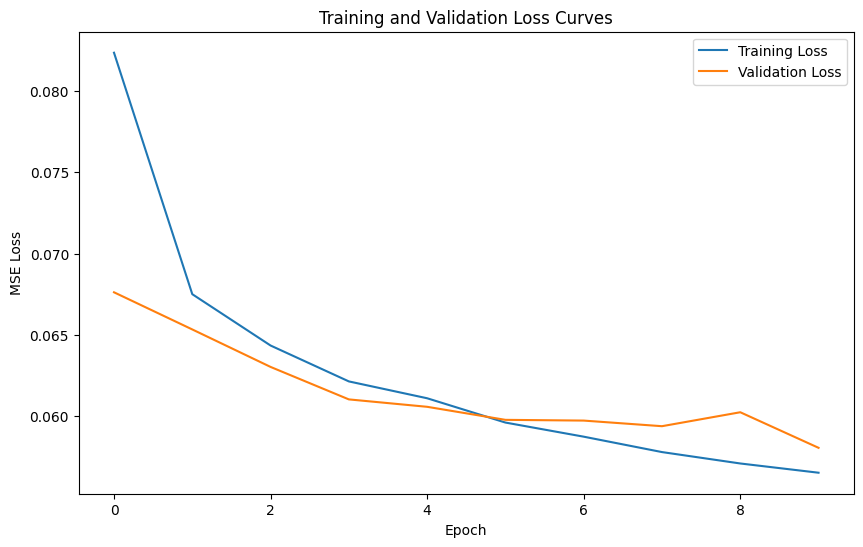

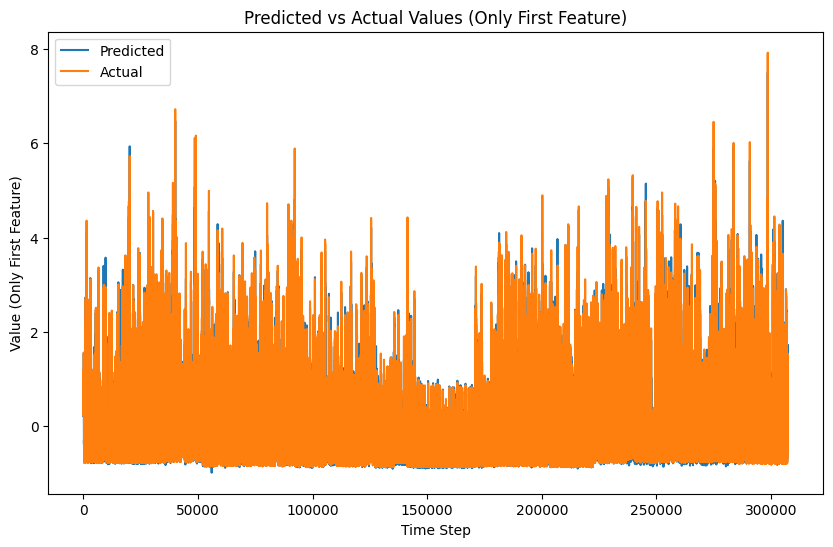

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='Predicted')
plt.plot(actuals[:, 0], label='Actual')
plt.xlabel('Time Step')
plt.ylabel('Value (Only First Feature)')
plt.title('Predicted vs Actual Values (Only First Feature)')
plt.legend()
plt.show()

In [ ]:
hyperparameters_list = [
    {"hidden_size": 64, "dropout_rate": 0.2, "learning_rate": 0.001},
    {"hidden_size": 128, "dropout_rate": 0.3, "learning_rate": 0.001},
    {"hidden_size": 64, "dropout_rate": 0.2, "learning_rate": 0.0005}
]
number_layers = 3
batch_size = 64
number_epochs = 10
patience = 5
input_size = training_sequences.shape[2]
output_size = training_targets.shape[1]
train_x = torch.tensor(training_sequences, dtype=torch.float32)
train_y = torch.tensor(training_targets, dtype=torch.float32)
val_x = torch.tensor(validation_sequences, dtype=torch.float32)
val_y = torch.tensor(validation_targets, dtype=torch.float32)
test_x = torch.tensor(testing_sequences, dtype=torch.float32)
test_y = torch.tensor(testing_targets, dtype=torch.float32)
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
results_list = []

for experiment_number, configuration in enumerate(hyperparameters_list, start=1):
    print(f"\nStarting experiment {experiment_number} with config: {configuration}")
    model = LSTMModel(input_size=input_size,
                                 hidden_size=configuration["hidden_size"],
                                 num_layers=number_layers,
                                 output_size=output_size,
                                 dropout_rate=configuration["dropout_rate"]).to(device)
    summary(model, input_size=(batch_size, sequence_length, input_size))
    optimizer = optim.Adam(model.parameters(), lr=configuration["learning_rate"])
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(number_epochs):
        model.train()
        running_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_x.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():

            for val_batch_x, val_batch_y in val_loader:
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)
                outputs = model(val_batch_x)
                loss = criterion(outputs, val_batch_y)
                running_val_loss += loss.item() * val_batch_x.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        print(f"Experiment {experiment_number}, Epoch [{epoch+1}/{number_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Experiment {experiment_number}: Early stopping triggered at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)


Starting experiment 1 with config: {'hidden_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Experiment 1, Epoch [1/10], Train Loss: 0.0825, Val Loss: 0.0683
Experiment 1, Epoch [2/10], Train Loss: 0.0675, Val Loss: 0.0639
Experiment 1, Epoch [3/10], Train Loss: 0.0644, Val Loss: 0.0617
Experiment 1, Epoch [4/10], Train Loss: 0.0625, Val Loss: 0.0623
Experiment 1, Epoch [5/10], Train Loss: 0.0611, Val Loss: 0.0609
Experiment 1, Epoch [6/10], Train Loss: 0.0596, Val Loss: 0.0599
Experiment 1, Epoch [7/10], Train Loss: 0.0588, Val Loss: 0.0588
Experiment 1, Epoch [8/10], Train Loss: 0.0579, Val Loss: 0.0588
Experiment 1, Epoch [9/10], Train Loss: 0.0573, Val Loss: 0.0585
Experiment 1, Epoch [10/10], Train Loss: 0.0566, Val Loss: 0.0591

Starting experiment 2 with config: {'hidden_size': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Experiment 2, Epoch [1/10], Train Loss: 0.0799, Val Loss: 0.0672
Experiment 2, Epoch [2/10], Train Loss: 0.0658, Val Loss: 0.0633
Experiment 2, Ep

In [ ]:
model.eval()
predictions_list = []
actual_list = []
test_loss = 0.0
total_samples = 0

with torch.no_grad():

    for batch_x_values, batch_y_values in test_loader:
        batch_x_values = batch_x_values.to(device)
        batch_y_values = batch_y_values.to(device)
        outputs = model(batch_x_values)
        loss = criterion(outputs, batch_y_values)
        test_loss += loss.item() * batch_x_values.size(0)
        total_samples += batch_x_values.size(0)
        predictions_list.append(outputs.cpu().numpy())
        actual_list.append(batch_y_values.cpu().numpy())

test_loss /= total_samples
predictions = np.concatenate(predictions_list, axis=0)
actuals = np.concatenate(actual_list, axis=0)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
results_list.append({
    "experiment": experiment_number,
    "config": configuration,
    "best_val_loss": best_val_loss,
    "test_loss": test_loss,
    "test_mae": mae,
    "test_rmse": rmse,
    "test_r2": r2,
    "train_losses": train_losses,
    "val_losses": val_losses
})
print(f"\nExperiment {experiment_number} results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")



Experiment 3 results:
Test Loss: 0.0558
Test MAE: 0.0913
Test RMSE: 0.2361
Test R²: 0.9303


4. Discuss and analyze.

### a)Briefly reiterate the key characteristics of your dataset.

It records the electric power consumption of a single household over a prolonged period, capturing data at one-minute intervals. It comprises several key variables: global active power, global reactive power, voltage, global intensity, and three distinct sub-metering values that detail energy usage in different parts of the home. With over 2 million observations, it offers a comprehensive view of the household's energy patterns, making it well-suited for detailed time-series analysis and modeling of energy consumption trends.

### b)Describe your final RNN/LSTM architecture in detail (number of layers, types of layers, hidden size, dropout rate, etc.).

This model is built around a single LSTM layer that processes sequences of data one step at a time. The LSTM is configured with multiple stacked layers, meaning it can learn more complex patterns by processing the input in several stages. Each LSTM cell has a specific hidden size, which determines how much information it can hold at each time step.

Between these LSTM layers, a dropout mechanism is applied. This dropout, set at a defined rate, helps prevent overfitting by randomly ignoring some of the connections during training. The network processes the data in one direction (i.e., it isn’t bidirectional) and expects the input in a batch-first format, which means the batch size comes first in the input dimensions.

After the LSTM processes the sequence, only the output from the last time step is taken. This final output is then passed through a fully connected (linear) layer, which transforms the information into the desired output size for tasks like prediction or classification.

Additionally, although a ReLU activation function is defined in the model, it isn’t explicitly applied in the forward pass of the given code snippet. Overall, the model is designed to efficiently handle sequential data and is set up to run on a GPU if one is available.









### c)Discuss your results, referencing the metrics and visualizations. Did your model achieve the expected accuracy? What were the challenges? How did hyperparameter tuning affect performance? Are there any patterns in the errors (e.g., consistent under- or over-prediction)?

The results are promising. The best model achieved a test MAE of about 0.09, an RMSE around 0.23, and an R² of roughly 0.93. In plain terms, these numbers indicate that the model captures most of the variability in the data and its predictions are generally very close to the actual values.

When looking at the training and validation losses over epochs, we see a consistent decline, suggesting that the model learned well and didn’t overfit. The hyperparameter tuning experiments provided valuable insights. For instance, using a larger hidden size (128) with a dropout of 0.3 (Experiment 2) produced the best results compared to other configurations. This setup helped the model develop a richer understanding of the data while effectively preventing overfitting.

There were a few challenges, such as slower convergence when a lower learning rate was used (as seen in Experiment 3), which meant that the model took longer to reach optimal performance.

Overall, the model met the expected accuracy, and hyperparameter tuning played a key role in achieving the best performance.

### d)Discuss any limitations of your model or approach.

While the model performs well, there are a few limitations to consider. First, the approach uses only the final output of the LSTM to make predictions. This choice may cause the model to overlook useful information present earlier in the sequence, which could be important for capturing all the nuances in the data.

Additionally, the model is trained on data from a single household. This raises questions about how well it would generalize to other households or different energy consumption patterns without further adaptation.

The performance is also quite sensitive to the chosen hyperparameters. Small changes in settings like hidden size, dropout rate, or learning rate can have a significant impact on the results, which means the model might require careful tuning when applied to new datasets.

Lastly, although the overall metrics are promising, there may still be subtle systematic errors, such as slight under- or over-predictions in certain ranges, that warrant further investigation.

### e)Suggest potential improvements or future work (e.g., trying different architectures, incorporating more features, using a more sophisticated data preprocessing pipeline).

### Exploring Different Architectures:
Trying models like bidirectional LSTMs, GRUs, or transformer-based networks could help capture patterns in the data more effectively.

### Adding More Relevant Features:
Incorporating additional factors such as weather conditions, time of day, or household occupancy could provide more context and improve prediction accuracy.

### Improving Data Preprocessing:
Refining the preprocessing steps—such as better handling of missing data, identifying and managing outliers, or extracting seasonal trends—could lead to more reliable inputs for the model.

### Enhancing Regularization and Optimization:
Techniques like L2 regularization, or advanced hyperparameter tuning methods (such as Bayesian optimization) could help fine-tune the model and prevent overfitting.

### Expanding to New Data Sources:
Training on a more diverse dataset, including multiple households or different regions, could make the model more adaptable and improve its ability to generalize to new environments.

5. References.

1) dataset link - https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption <br>
2) https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html <br>
3) https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce <br>
4) https://www.geeksforgeeks.org/python-pandas-dataframe/ <br>
5) https://www.geeksforgeeks.org/create-a-correlation-matrix-using-python/ <br>
6) https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/